<a href="https://colab.research.google.com/github/pgauravv/Peak-Energy-Forecast/blob/master/Peak_Energy__Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries

import os
import sys
from itertools import product
import datetime

import pandas as pd
import numpy as np
import json
from math import radians, sin, cos, acos
import scipy
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing datasets
url='https://github.com/pgauravv/Peak-Energy-Forecast/blob/master/data/energy_temp.xlsx?raw=true'
energy_consumption=pd.read_excel(url)
energy_h = pd.read_excel(url, index_col=[0], parse_dates=[0])
energy_consumption.columns

Index(['tstp', 'Total_E', 'Temp_Avg', 'Temp_ref'], dtype='object')

In [3]:
energy_consumption.head()

,tstp,Total_E,Temp_Avg,Temp_ref
0,2013-01-13,72673,3.6,4.8
1,2013-01-16,89570,0.1,4.9
2,2013-01-21,87635,2.5,5.1
3,2013-01-24,87811,1.8,5.2
4,2013-02-01,73379,9.3,5.6


**The dataset contains electricity consumption and average temperature of France from 2012 to 2019** 


In [4]:
energy_consumption["tstp_f"]=pd.to_datetime(energy_consumption["tstp"])
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2953 entries, 0 to 2952
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tstp      2953 non-null   datetime64[ns]
 1   Total_E   2953 non-null   int64         
 2   Temp_Avg  2953 non-null   float64       
 3   Temp_ref  2953 non-null   float64       
 4   tstp_f    2953 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 115.5 KB


In [5]:
energy_consumption.describe()

,Total_E,Temp_Avg,Temp_ref
count,2953.000000,2953.000000,2953.00000
mean,61632.979004,12.693038,12.55549
std,11650.990075,6.284855,5.71833
min,41983.000000,-4.900000,4.60000
25%,53582.000000,7.700000,6.90000
50%,57770.000000,12.300000,12.40000
75%,70513.000000,17.800000,18.00000
max,102098.000000,29.700000,21.30000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6b5ace0f0>,
      dtype=object)

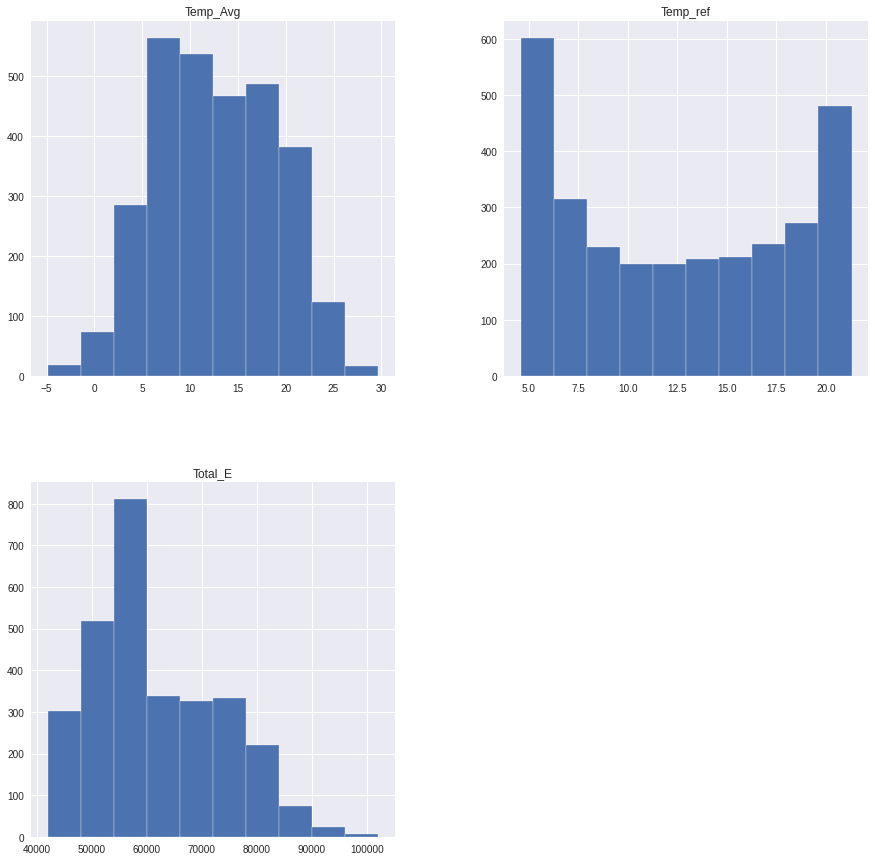

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
energy_consumption.hist(figsize=(15,15),edgecolor='white') 

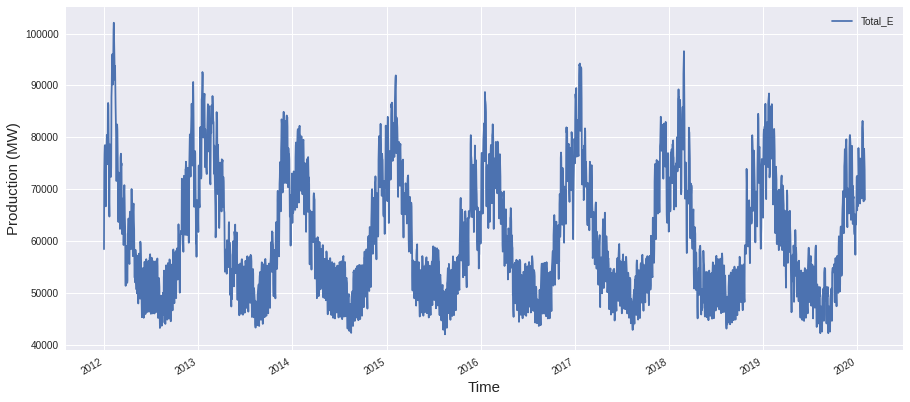

In [7]:
# Analysis on distribution of data in time series
fig, ax = plt.subplots(figsize=(15,7))
energy_consumption.plot(ax=ax,x="tstp_f",y="Total_E")
ax.set_xlabel("Time",fontsize=15)
ax.set_ylabel("Production (MW)",fontsize=15)
plt.show()

In [8]:
energy_consumption["day"]=energy_consumption.apply(lambda row: row["tstp_f"].strftime("%Y-%m-%d"),axis=1)
energy_consumption.head()
len(energy_consumption)

2953

In [9]:
energy_consumption_daily=energy_consumption.groupby(["day"]).sum()
len(energy_consumption_daily)

2953

In [10]:
#Generating features for additional insights

energy_consumption["energy"]=energy_consumption.apply(lambda row: row["Total_E"]*30*60/3600,axis=1)
energy_consumption["day"]=energy_consumption.apply(lambda row: row["tstp_f"].strftime("%Y-%m-%d"),axis=1)
energy_consumption["month"]=energy_consumption.apply(lambda row: int(row["tstp_f"].strftime("%m")),axis=1)
energy_consumption["year"]=energy_consumption.apply(lambda row: int(row["tstp_f"].strftime("%Y")),axis=1)
energy_consumption["weekday"]=energy_consumption.apply(lambda row: row["tstp_f"].weekday(),axis=1)
energy_consumption["hour"]=energy_consumption.apply(lambda row: int(row["tstp_f"].strftime("%H")),axis=1)
energy_consumption["year_day"]=energy_consumption.apply(lambda row: int(row["tstp_f"].strftime("%j")),axis=1)

energy_consumption.head()

,tstp,Total_E,Temp_Avg,Temp_ref,tstp_f,day,energy,month,year,weekday,hour,year_day
0,2013-01-13,72673,3.6,4.8,2013-01-13,2013-01-13,36336.5,1,2013,6,0,13
1,2013-01-16,89570,0.1,4.9,2013-01-16,2013-01-16,44785.0,1,2013,2,0,16
2,2013-01-21,87635,2.5,5.1,2013-01-21,2013-01-21,43817.5,1,2013,0,0,21
3,2013-01-24,87811,1.8,5.2,2013-01-24,2013-01-24,43905.5,1,2013,3,0,24
4,2013-02-01,73379,9.3,5.6,2013-02-01,2013-02-01,36689.5,2,2013,4,0,32


In [11]:
energy_daily_consumption=energy_consumption.groupby(["day"]).sum()["energy"]
energy_daily_consumption.head()

day
2012-01-01    29207.0
2012-01-02    36664.5
2012-01-03    38365.0
2012-01-04    39193.5
2012-01-05    39245.5
Name: energy, dtype: float64

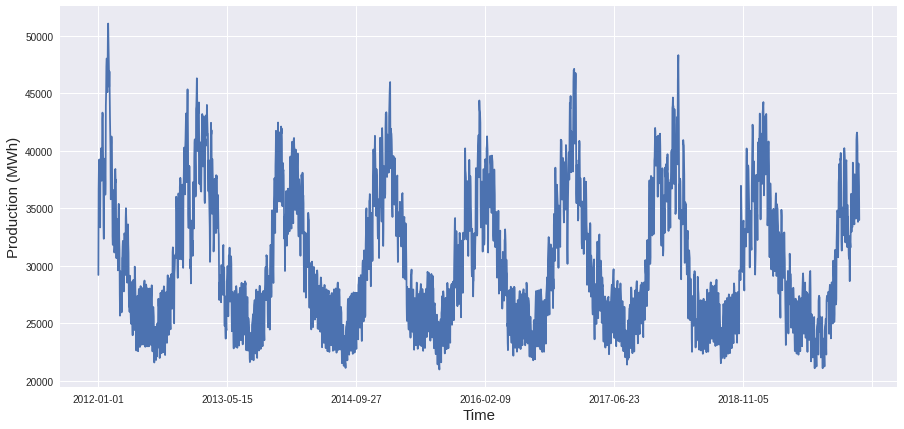

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
energy_daily_consumption.plot(ax=ax,y="energy",legend=None)
ax.set_xlabel("Time",fontsize=15)
ax.set_ylabel("Production (MWh)",fontsize=15)
plt.show()


In [0]:
heatmap_=pd.pivot_table(energy_consumption, values="energy", index=['month'],columns=['hour'], aggfunc=np.mean)

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_heatmap(fig, ax,df,title):
   
    m, n = len(df.index),len(df.columns)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlabel(title, fontsize=15)
    #ax.set_ylabel('Candidates' , fontsize=15)
    #ax.set_title('Who with who', fontsize=15, fontweight='bold')
    ax = plt.imshow(df, interpolation='nearest', cmap='seismic').axes

    _ = ax.set_xticks(np.linspace(0, n-1, n))
    _ = ax.set_xticklabels(df.columns,rotation=45)
    _ = ax.set_yticks(np.linspace(0, m-1, m))
    _ = ax.set_yticklabels(df.index)


    ax.grid('off')
    ax.xaxis.tick_top()
    path_effects = [patheffects.withSimplePatchShadow(shadow_rgbFace=(1,1,1))]

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(cax=cax)
#     for i, j in product(range(m), range(n)):
#         _ = ax.text(j, i, '{0:.2f}'.format(df.iloc[i, j]),
#             size='medium', ha='center', va='center',path_effects=path_effects)
    
    return fig,ax

In [15]:
df_ptg=energy_consumption
df_ptg.head()


,tstp,Total_E,Temp_Avg,Temp_ref,tstp_f,day,energy,month,year,weekday,hour,year_day
0,2013-01-13,72673,3.6,4.8,2013-01-13,2013-01-13,36336.5,1,2013,6,0,13
1,2013-01-16,89570,0.1,4.9,2013-01-16,2013-01-16,44785.0,1,2013,2,0,16
2,2013-01-21,87635,2.5,5.1,2013-01-21,2013-01-21,43817.5,1,2013,0,0,21
3,2013-01-24,87811,1.8,5.2,2013-01-24,2013-01-24,43905.5,1,2013,3,0,24
4,2013-02-01,73379,9.3,5.6,2013-02-01,2013-02-01,36689.5,2,2013,4,0,32


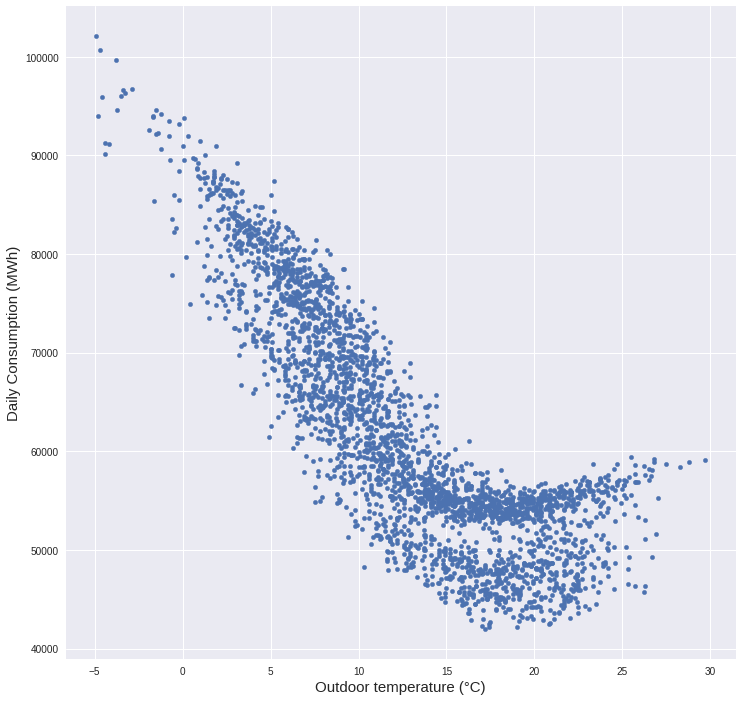

In [16]:
#Scatter Plot for insights on temperature and energy consumption

fig, ax = plt.subplots(figsize=(12,12))
df_ptg.plot(ax=ax,x="Temp_Avg",y="Total_E",kind="scatter")
ax.set_xlabel("Outdoor temperature (°C)", fontsize=15)
ax.set_ylabel("Daily Consumption (MWh)", fontsize=15)
plt.show()
ax.figure.savefig("temp_production.png")

In [0]:
heatmap_yearday=pd.pivot_table(energy_consumption, values="energy", index=['year_day'],columns=['hour'], aggfunc=np.mean)

In [0]:
heatmap_=pd.pivot_table(energy_consumption, values="energy", index=['month'],columns=['weekday'], aggfunc=np.mean)
heatmap_.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
heatmap_.index=["January","February","March","April","May","June","July","August","September","October","November","December"]

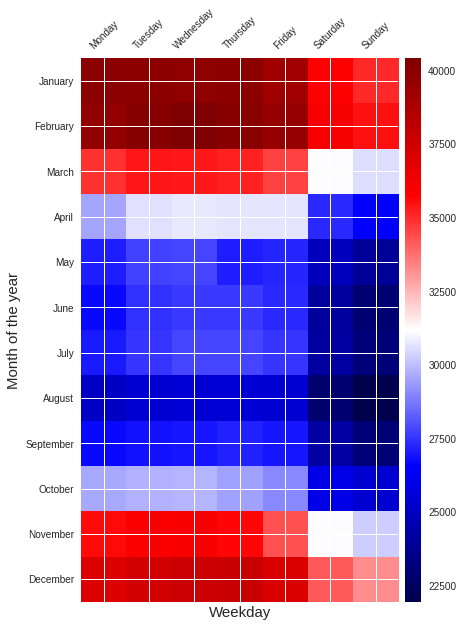

In [19]:
#Heatmaps to deep dive in energy consumped by different days of week and months

fig, ax = plt.subplots(figsize=(7,10))
fig,ax=plot_heatmap(fig, ax,heatmap_,"test")
ax.set_xlabel("Weekday",fontsize=15)
ax.set_ylabel("Month of the year",fontsize=15)
plt.show()

In [20]:
energy_consumption.tail()

,tstp,Total_E,Temp_Avg,Temp_ref,tstp_f,day,energy,month,year,weekday,hour,year_day
2948,2016-11-29,81917,2.9,6.8,2016-11-29,2016-11-29,40958.5,11,2016,1,0,334
2949,2016-12-01,81815,2.9,6.5,2016-12-01,2016-12-01,40907.5,12,2016,3,0,336
2950,2016-12-15,77659,5.7,5.2,2016-12-15,2016-12-15,38829.5,12,2016,3,0,350
2951,2016-12-17,69762,5.0,5.1,2016-12-17,2016-12-17,34881.0,12,2016,5,0,352
2952,2016-12-27,71579,4.8,4.7,2016-12-27,2016-12-27,35789.5,12,2016,1,0,362


# ***Splitting Data In train and test set***

In [0]:
# Splitting the data in training and test set 
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

# **Piecewise Regression**

In [0]:
#Fitiing a piecewise regression to study relationship in independent variables

def ptg_model(x, a, b, x0):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: a*x+b , lambda x:a*x0+b])

def get_model_ptg(x,y):
    x0_min = 0
    x0_max = 20
    a_min=-5000
    a_max=-1500
    b_min=90000
    b_max=150000
    bounds_min = [a_min, b_min, x0_min]
    bounds_max = [a_max, b_max, x0_max]
    bounds = (bounds_min, bounds_max)
    popt, pcov = scipy.optimize.curve_fit(ptg_model, x, y, bounds=bounds)
    a= popt[0]
    b = popt[1]
    x0 = popt[2]
    return a,b,x0

In [0]:
model=get_model_ptg(list(df_ptg["Temp_Avg"]),list(df_ptg["Total_E"]))
new_x = np.linspace(df_ptg["Temp_Avg"].min(), df_ptg["Temp_Avg"].max(), 100)

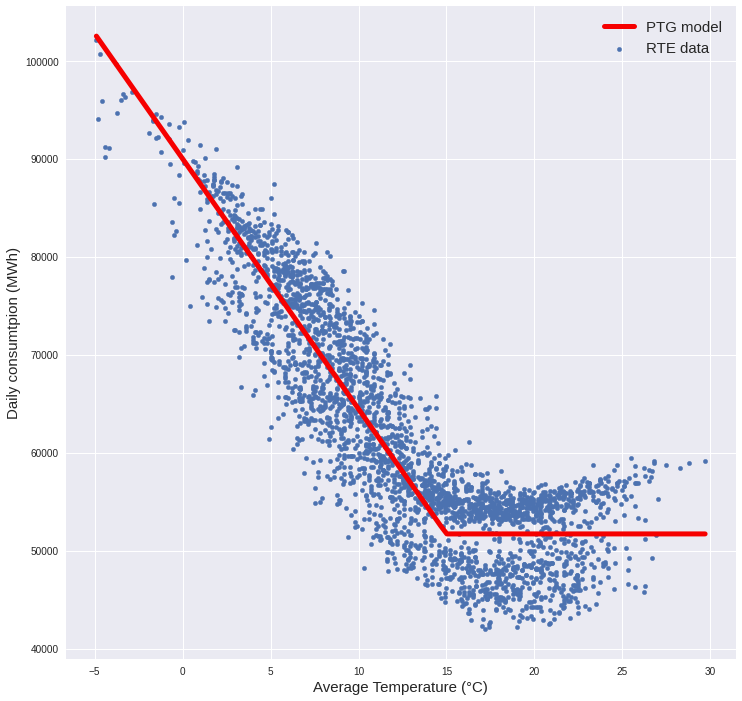

In [24]:
fig, ax = plt.subplots(figsize=(12,12))
df_ptg.plot(ax=ax,x="Temp_Avg",y="Total_E",kind="scatter",label="RTE data")
ax.plot(new_x,ptg_model(new_x, model[0], model[1], model[2]),color="#F60000",linewidth=5.0,label="PTG model");
ax.set_xlabel("Average Temperature (°C)", fontsize=15)
ax.set_ylabel("Daily consumtpion (MWh)", fontsize=15)
plt.legend(prop={'size': 15})
plt.show()


In [25]:
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn.metrics import explained_variance_score, r2_score,mean_absolute_error
from sklearn.model_selection import *

df_totest=df_ptg.copy()

df_totest.head()

df_split=df_totest.copy()
for param in ['Temp_Avg','Temp_ref','Total_E','month','weekday','year','year_day']:
    df_split[param]=df_split.apply(lambda row: (row[param]-df_split[param].mean())/(df_split[param].max()-df_split[param].min()),axis=1)
print(df_split.head())

X_train, X_test, y_train, y_test = train_test_split(np.array(df_split["Temp_Avg"]),np.array(df_split["Total_E"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

        tstp   Total_E  Temp_Avg  Temp_ref  ...      year   weekday  hour  year_day
0 2013-01-13  0.183648 -0.262805 -0.464401  ... -0.318278  0.500113     0 -0.461290
1 2013-01-16  0.464726 -0.363961 -0.458413  ... -0.318278 -0.166554     0 -0.453071
2 2013-01-21  0.432538 -0.294596 -0.446437  ... -0.318278 -0.499887     0 -0.439372
3 2013-01-24  0.435466 -0.314828 -0.440448  ... -0.318278  0.000113     0 -0.431153
4 2013-02-01  0.195393 -0.098065 -0.416496  ... -0.318278  0.166780     0 -0.409235

[5 rows x 12 columns]
Number of elements for the training set: 2362 samples
Number of elements for the testing set: 591 samples


**Building Piecewise Regression model**

In [0]:
def get_model_ptg(x,y):
    x0_min = 0
    x0_max = 20
    a_min=-5000
    a_max=-1500
    b_min=90000
    b_max=150000
    bounds_min = [a_min, b_min, x0_min]
    bounds_max = [a_max, b_max, x0_max]
    bounds = (bounds_min, bounds_max)
    popt, pcov = scipy.optimize.curve_fit(ptg_model, x, y, bounds=bounds)
    a= popt[0]
    b = popt[1]
    x0 = popt[2]
    return a,b,x0

### **Applying Kfold cross validation**

In [0]:

kf = KFold(n_splits=10)
from datetime import datetime
from time import time
import time

In [0]:
def get_bestptgmodel(X_train, X_test, y_train, y_test,kf):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]

        model=get_model_ptg(X_training,y_training)
        toc=time.time()-tic
        y_pred=[]
        for value in X_validation:
            y_pred.append(ptg_model(value,model[0],model[1],model[2]))

        print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
            print("Best model:",r2score_ref,toc)

    
    # Test the best model in the testing set
    y_pred=[]
    for value in X_test:
        y_pred.append(ptg_model(value,best_model[0],best_model[1],best_model[2]))
        
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

### **Selecting the best model**

In [29]:
result_ptg=get_bestptgmodel(X_train, X_test, y_train, y_test,kf)
result_ptg

-222384114678.83582 89973.36626449908
Best model: -222384114678.83582 0.025628328323364258
-239163045115.1468 89983.69678840516
-240959863574.6063 90019.60652705638
-222547847171.90988 89969.40983415928
-222699440381.825 90135.38225319269
-200405062989.2544 90027.21938742635
Best model: -200405062989.2544 0.024723052978515625
-214550469730.18408 90025.3950579807
-199086365389.91492 90044.40364343557
Best model: -199086365389.91492 0.017267942428588867
-241885113201.54794 89988.080305886
-203336292562.83487 89993.31230890672
Final results: -204447249359.47833 90018.6735115716 0.017267942428588867


((-4999.977188822332, 90000.00000018353, 10.0),
 -204447249359.47833,
 90018.6735115716,
 0.017267942428588867)

# **XG Boost**

In [0]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [31]:
energy_h.head()

,Total_E,Temp_Avg,Temp_ref
tstp,,,
2013-01-13,72673,3.6,4.8
2013-01-16,89570,0.1,4.9
2013-01-21,87635,2.5,5.1
2013-01-24,87811,1.8,5.2
2013-02-01,73379,9.3,5.6


In [32]:
energy_h.sort_index(inplace=True)
energy_h.head(3)

,Total_E,Temp_Avg,Temp_ref
tstp,,,
2012-01-01,58414,11.7,4.6
2012-01-02,73329,8.4,4.6
2012-01-03,76730,8.4,4.6


### **Visualising the training and test time series**

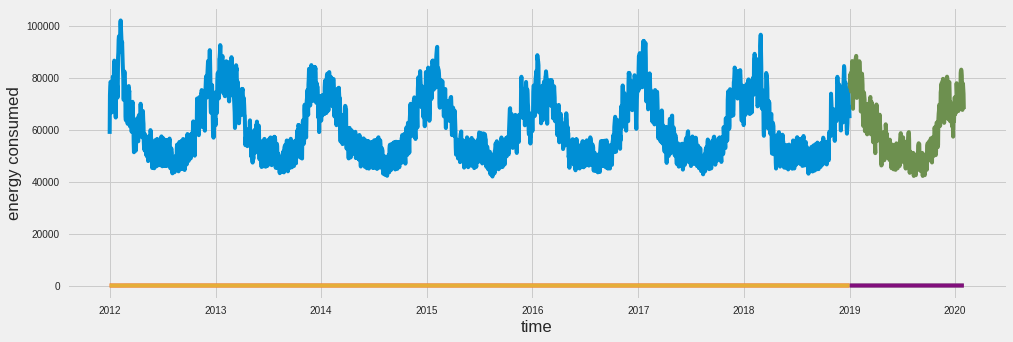

In [33]:

train, test = split_data(energy_h, '01-Jan-2019')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()
ax.figure.savefig("energy_pattern.png")

### **Creating the features for enhancing the performance of model**

In [0]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['temp_avg']=df['Temp_Avg']
    df['temp_ref']=df['Temp_ref']
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','temp_avg','temp_ref']]
    return X

In [35]:
X_train, y_train = create_features(train), train['Total_E']
X_test, y_test   = create_features(test), test['Total_E']

X_train.shape, y_train.shape
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temp_avg,temp_ref
tstp,,,,,,,,,,
2012-01-01,0,6,1,1,2012,1,1,52,11.7,4.6
2012-01-02,0,0,1,1,2012,2,2,1,8.4,4.6
2012-01-03,0,1,1,1,2012,3,3,1,8.4,4.6
2012-01-04,0,2,1,1,2012,4,4,1,8.1,4.6
2012-01-05,0,3,1,1,2012,5,5,1,9.2,4.6


In [36]:
#Fittng a XG Boost algorithm 
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100, #stop if 50 consequent rounds without decrease of error
        verbose=True) # Change verbose to True if you want to see it train

[20:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56535.1	validation_1-rmse:56193.7
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:50929.5	validation_1-rmse:50527.6
[2]	validation_0-rmse:45884.8	validation_1-rmse:45434.8
[3]	validation_0-rmse:41342.9	validation_1-rmse:40844.7
[4]	validation_0-rmse:37256.2	validation_1-rmse:36751
[5]	validation_0-rmse:33577.7	validation_1-rmse:33024.5
[6]	validation_0-rmse:30265.7	validation_1-rmse:29701.1
[7]	validation_0-rmse:27285.8	validation_1-rmse:26733.5
[8]	validation_0-rmse:24606.6	validation_1-rmse:24046.6
[9]	validation_0-rmse:22196.8	validation_1-rmse:21633.5
[10]	validation_0-rmse:20029.5	validation_1-rmse:19434.4
[11]	validation_0-rmse:18080.4	validation_1-rmse:17497.8
[12]	validation_0-rmse:16326.3	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

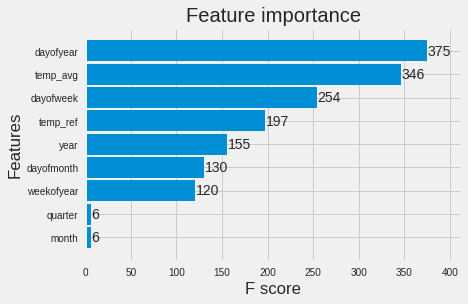

In [37]:
#Feature importance analysis
xgb.plot_importance(reg, height=0.9)
ax.figure.savefig("feature_imp.png")

In [0]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(energy_h.index,energy_h, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

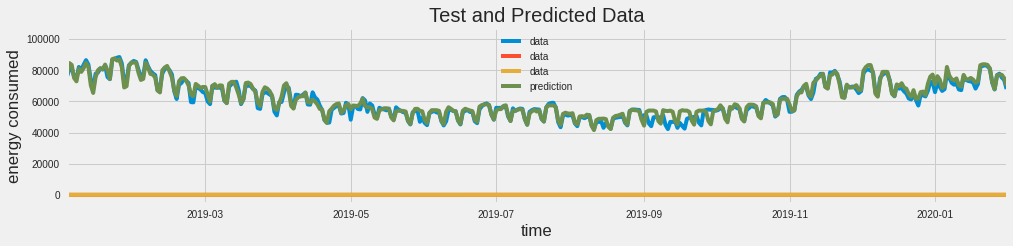

In [40]:
X_test_pred = reg.predict(X_test)
    
#plot_performance(energy_h, energy_h.index[0].date(), energy_h.index[-1].date(),'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),'Test and Predicted Data')

#plot_performance(y_test, '01-01-2019', '02-01-2019', 'January 2019 Snapshot')
plt.legend()
plt.show()

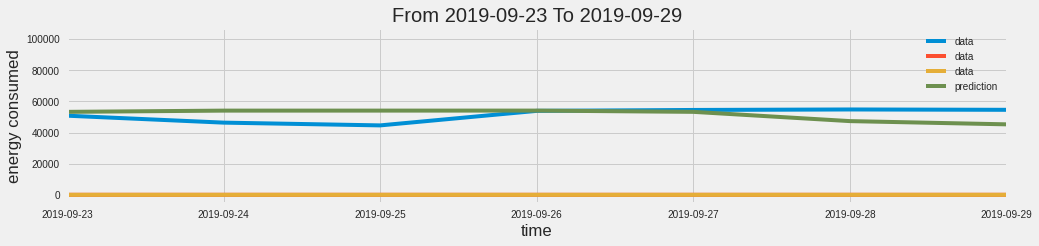

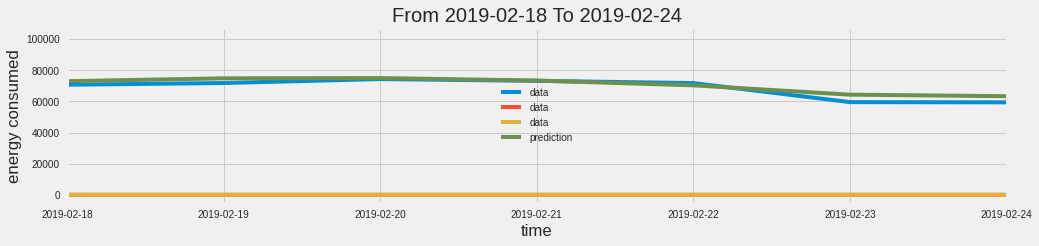

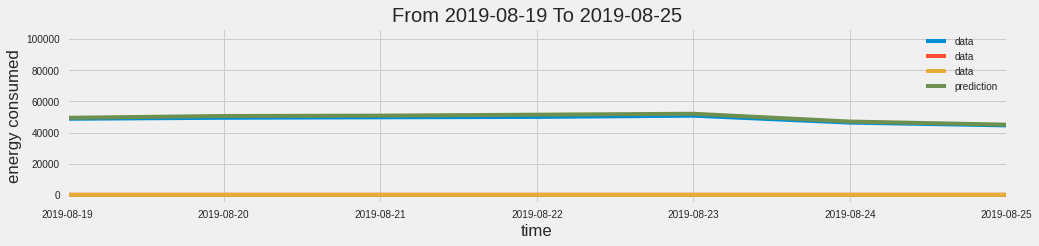

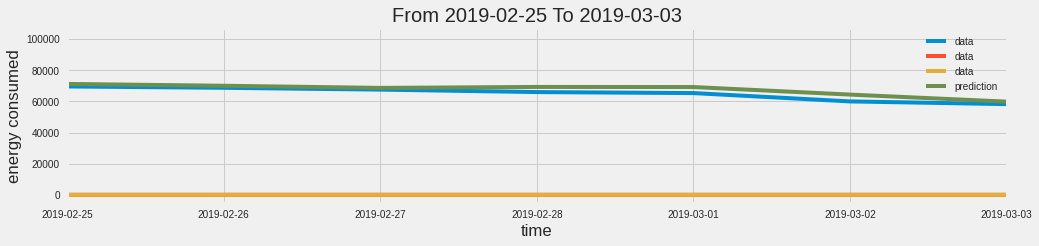

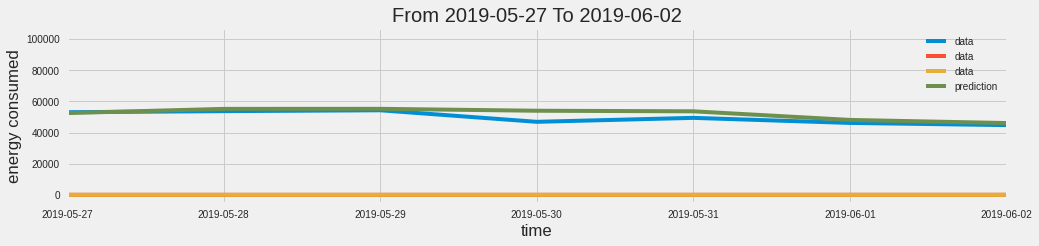

In [41]:
random_weeks = X_test[['year', 'weekofyear']].sample(5)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())

# **Algorithm Metric Evaluation**

In [42]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

6635191.164240699

In [43]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

1740.2791633702532

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
mean_absolute_percentage_error(y_test,X_test_pred)

3.037889354603389

In [46]:
#Checking the errors to determine performance of model

error_by_week = []
random_weeks = X_test[['year', 'weekofyear']].sample(5)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    error_by_week.append(mean_absolute_percentage_error(y_test[index], X_test_pred[index]))
pd.Series(error_by_week, index=random_weeks.index)

tstp
2019-07-06     1.423036
2019-08-03     2.119607
2019-09-15    12.708811
2019-02-07     1.766321
2019-11-13     1.969035
dtype: float64

In [47]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,temp_avg,temp_ref
tstp,,,,,,,,,,
2019-01-02,0,2,1,1,2019,2,2,1,5.6,4.6
2019-01-03,0,3,1,1,2019,3,3,1,3.1,4.6
2019-01-04,0,4,1,1,2019,4,4,1,2.4,4.6
2019-01-05,0,5,1,1,2019,5,5,1,3.2,4.6
2019-01-06,0,6,1,1,2019,6,6,1,4.2,4.6


In [48]:
X_test['Total_E_MW'] = y_test
X_test['MW_Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['year','month','dayofmonth']) \
   .mean()[['Total_E_MW','MW_Prediction','error','abs_error']]

error_by_day.sort_values('error', ascending=True).head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Total_E_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                       
2019 9     11               42208   53777.820312 -11569.820312  11569.820312
           18               42514   54063.589844 -11549.589844  11549.589844
           17               44240   54339.750000 -10099.750000  10099.750000
           4                44076   54091.695312 -10015.695312  10015.695312
           25               44578   54063.589844  -9485.589844   9485.589844
           10               44811   53923.332031  -9112.332031   9112.332031
           3                45853   54091.695312  -8238.695312   8238.695312
           24               46355   54063.589844  -7708.589844   7708.589844
           16               46174   53576.996094  -7402.996094   7402.996094
     4     22               46402   53720.503906  -7318.503906   7318.503906

In [49]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

Total_E_MW  MW_Prediction      error  abs_error
year month dayofmonth                                                 
2019 7     22               56160   56154.546875   5.453125   5.453125
     4     20               47991   47996.765625  -5.765625   5.765625
           21               46237   46249.425781 -12.425781  12.425781
     10    27               51615   51627.703125 -12.703125  12.703125
     2     9                67033   67012.570312  20.429688  20.429688
     4     12               65630   65651.867188 -21.867188  21.867188
     6     14               53684   53644.464844  39.535156  39.535156
     5     3                57171   57127.789062  43.210938  43.210938
     1     17               80474   80529.117188 -55.117188  55.117188
     7     14               45051   44991.578125  59.421875  59.421875

# **Anomaly Detection to Find the Peak Electricity Consumption**

In [0]:
# Using Anomaly Detection for determing the upper peak and lower peak
s=energy_h['Total_E']

In [0]:
s.head()

In [0]:
!pip install adtk


In [0]:
from adtk.data import validate_series
s = validate_series(s)

In [0]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.96, low=0.04)
anomalies = quantile_ad.fit_detect(s)

In [0]:
anomalies

In [0]:
from adtk.visualization import plot
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [0]:
X_test